# Chapter 12: IPW and Marginal Structural Models
This notebook goes through Chapter 12 of “Hernán MA, Robins JM (2019). Causal Inference. Boca Raton: Chapman & Hall/CRC, forthcoming”, which details the use of inverse probability weights for causal inference using models. Within this notebook, I will use *zEpid* to recreate the analyses detailed in chapter 12. As an introduction to causal inference and the associated methods, I highly recommend reviewing this book, which the preprint is available for free at: https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/

### Data Preparation
Data comes from the National Health and Nutrition Examination Survey Data I Epidemiologic
Follow-up Study (NHEFS). The NHEFS was jointly initiated by the National Center for Health Statistics and the
National Institute on Aging in collaboration with other agencies of the United States Public Health Service. A
detailed description of the NHEFS, together with publicly available data sets and documentation, can be found at
wwwn.cdc.gov/nchs/nhanes/nhefs/ 

The data set used in the book and this tutorial is a subset of the full NHEFS. First, we will load the data and run some basic variable manipulations. We are interested in estimating the average causal effect ($E[Y^{a=1}] - E[Y^{a=0}]$) of stopping smoking (`qsmk`) on 10-year weight change (`wt82_71`). See Fine Point 12.2 for details on problems with this example (specifically, there is selection bias induced by how our treatment variable is defined)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

from zepid.causal.ipw import IPTW

df = pd.read_csv('Data/nhefs.csv')
df.dropna(subset=['sex', 'age', 'race', 'wt82', 'ht', 
                  'school', 'alcoholpy', 'smokeintensity'], 
         inplace=True)

# recoding some variables
df['inactive'] = np.where(df['active'] == 2, 1, 0)
df['no_exercise'] = np.where(df['exercise'] == 2, 1, 0)
df['university'] = np.where(df['education'] == 5, 1, 0)

# Subsetting only variables of interest
df = df[['wt82_71', 'qsmk', 'sex', 'age', 'race', 'wt71', 'wt82', 'ht', 
         'school', 'alcoholpy', 'smokeintensity', 'smokeyrs', 
         'education', 'exercise', 'active', 'death']]

# creating quadratic terms
for col in ['age', 'wt71', 'smokeintensity', 'smokeyrs']:
    df[col+'_sq'] = df[col] * df[col]



## Section 12.1
We can calculate the average associational measure as $\hat{E}[Y|A=1] - \hat{E}[Y|A=0]$. However, we will be unable to (or unwilling) to interpret this as a causal effect. We can calculate this using ordinary least squares to calculate the associational measure. For this, we will only use `statsmodels` implementation via `ols`. `ols`, unlike `OLS`, automatically adds an intercept to our model and looks more like R's regression implementations. I mention this distinction since jfiedler uses `OLS` while I will use `ols`. Other than this distinction, the approaches are equivalent

In [2]:
print('Estimation of association')
print('--------------------------------------')
print('Weight change (kg) among quitters')
print('E[Y|A=1] = ', np.round(np.mean(df.loc[df['qsmk'] == 1, 'wt82_71']), 2), '\n')
print('Weight change (kg) among non-quitters')
print('E[Y|A=1] = ', np.round(np.mean(df.loc[df['qsmk'] == 0, 'wt82_71']), 2))
print('--------------------------------------')

Estimation of association
--------------------------------------
Weight change (kg) among quitters
E[Y|A=1] =  4.53 

Weight change (kg) among non-quitters
E[Y|A=1] =  1.98
--------------------------------------


In [3]:
m = smf.ols('wt82_71 ~ qsmk', df).fit()
beta = m.params[1]
lcl = np.round(m.conf_int()[0]['qsmk'], 2)
ucl = np.round(m.conf_int()[1]['qsmk'], 2)

print('Associational Difference')
print('--------------------------------------')
print('E[Y|A=1] - E[Y|A=0] = ', np.round(beta, 2))
print('95% CL: '+str(lcl)+', '+str(ucl))
print('--------------------------------------')

Associational Difference
--------------------------------------
E[Y|A=1] - E[Y|A=0] =  2.54
95% CL: 1.66, 3.43
--------------------------------------


## Section 12.2
To estimate the causal effect of quitting smoking on weight change (in kg), we will use inverse probability of treatments weights. Specifically, we will assume $Y^a \amalg A|L$, where $L$ includes sex, race, age, education, smoking duration, smoking intensity, exercise, recreational activity, and baseline weight. Weights will be constructed via the following formula
$$ \hat{w}_i = \frac{1}{\widehat{\Pr}(A_i=a | L_i)}$$
where the probability is estimated using a logistic regression model.

To estimate $\hat{w}$, we can use `IPTW` in *zEpid*. We will initialize `IPTW` with the data set (`df`), treatment (`qsmk`), and we will specify the optional argument `stabilized=False` to request the above $w$ formulation. We then specify the regression model to estimate our weights. We will fit the following regression model
$$logit(\widehat{\Pr}(A=1|L)) = \beta_0 + \beta L$$
where $L$ is a matrix containing all the variables in our model.  ...

One advantage of the R approach to fitting models is that we can use `patsy` magic. Specifically, we will avoid creating indicator (dummy) variables for our categorical variables. Instead we will use `C(...)`, which tells patsy we want that variable to be a categorical variables. We will do this for `active` and `exercise`. 

In [4]:
# initialize the IPTW class
iptw = IPTW(df, treatment='qsmk', outcome='wt82_71')

# Estimating weights
iptw.treatment_model('sex + race + age + age_sq + C(education) + smokeintensity + ' + 
                       'smokeintensity_sq + smokeyrs + smokeyrs_sq + C(exercise) + ' + 
                       'C(active) + wt71 + wt71_sq', 
                       stabilized=False, print_results=False)

# Specifying the marginal structural model
iptw.marginal_structural_model('qsmk')

# Calculating estimates
iptw.fit()

                     Weight Positivity Diagnostics
If the mean of the weights is far from either the min or max, this may
 indicate the model is incorrect or positivity is violated
Average weight should be
	1.0 for stabilized
	2.0 for unstabilized
----------------------------------------------------------------------
Mean weight:            1.996
Standard Deviation:     1.474
Minimum weight:         1.054
Maximum weight:         16.7

                Standardized Mean Differences
                      smd_w     smd_u
labels                               
C(education)       0.034662  0.195789
C(exercise)        0.028025  0.056850
C(active)          0.017729  0.074001
sex               -0.002854 -0.160263
race               0.006644 -0.177051
age                0.005852  0.281981
age_sq             0.006272  0.281608
smokeintensity    -0.024837 -0.216675
smokeintensity_sq -0.028577 -0.128894
smokeyrs          -0.003515  0.158918
smokeyrs_sq       -0.000546  0.178899
wt71              -0.

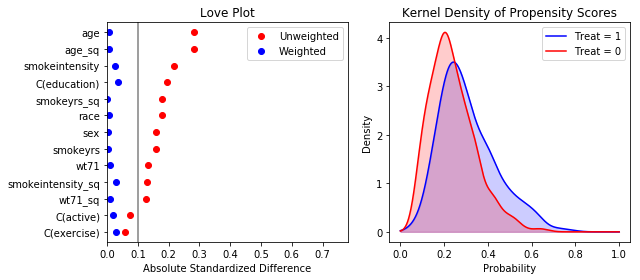

In [5]:
# diagnostics for weights
iptw.run_diagnostics()

The distribution of the weights match what is described in the book results. The average weight of 2 (as expected) with an min of 1.05 and max of 16.7. 

I ran some additional diagnostics in addition to what is discussed in the book. I created a Love plot, which assesses covariate balance measured by standardized mean differences. According to this measure, we have good balance by our measured covariates and weights. The density plot suggests there is a fair bit of overlap of propensity scores between treated and untreated. However, there are few treated individuals at the low end of the distribution and few untreated individuals at the higher end of the distribution.

In [6]:
# ATE estimate
iptw.summary(decimal=2)

              Inverse Probability of Treatment Weights                
Treatment:        qsmk            No. Observations:     1566                
Outcome:          wt82_71         No. Missing Outcome:  0                   
g-Model:          Logistic        Missing Model:        None                
Average Treatment Effect
----------------------------------------------------------------------
            ATE  SE(ATE)  95%LCL  95%UCL
labels                                  
Intercept  1.78     0.22    1.34    2.22
qsmk       3.44     0.53    2.41    4.47


Similar to discussed in the book, `IPTW` calculates confidence intervals using GEE with an independent correlation structure. This results in valid (but slightly conservative) confidence intervals. For further details see the book.

## Section 12.3
We will now repeat the analysis described in the previous section but using stabilized weights instead. Weights will now be constructed via the following formula
$$ \hat{w}_i = \frac{\widehat{\Pr}(A_i=a)}{\widehat{\Pr}(A_i=a | L_i)}$$
where the probability is estimated using a logistic regression model.

The only difference we make is that `IPTW` is initialized with `stabilized=True` instead

In [7]:
# initialize the IPTW class
iptw = IPTW(df, treatment='qsmk', outcome='wt82_71')

# Estimating weights
iptw.treatment_model('sex + race + age + age_sq + C(education) + smokeintensity + ' + 
                       'smokeintensity_sq + smokeyrs + smokeyrs_sq + C(exercise) + ' + 
                       'C(active) + wt71 + wt71_sq', 
                       stabilized=True, print_results=False)

# Specifying the marginal structural model
iptw.marginal_structural_model('qsmk')

# Calculating estimates
iptw.fit()

                     Weight Positivity Diagnostics
If the mean of the weights is far from either the min or max, this may
 indicate the model is incorrect or positivity is violated
Average weight should be
	1.0 for stabilized
	2.0 for unstabilized
----------------------------------------------------------------------
Mean weight:            0.999
Standard Deviation:     0.288
Minimum weight:         0.331
Maximum weight:         4.298

                Standardized Mean Differences
                      smd_w     smd_u
labels                               
C(education)       0.034662  0.195789
C(exercise)        0.028025  0.056850
C(active)          0.017729  0.074001
sex               -0.002854 -0.160263
race               0.006644 -0.177051
age                0.005849  0.281981
age_sq             0.006268  0.281608
smokeintensity    -0.024824 -0.216675
smokeintensity_sq -0.028563 -0.128894
smokeyrs          -0.003513  0.158918
smokeyrs_sq       -0.000546  0.178899
wt71              -0

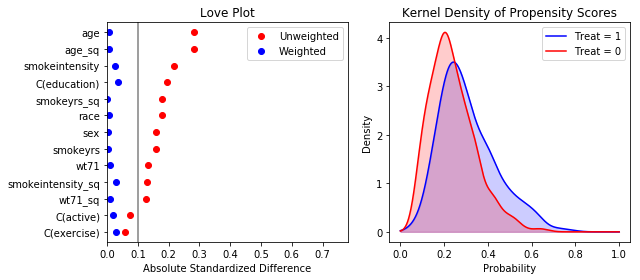

In [8]:
# diagnostics for weights
iptw.run_diagnostics()

In [9]:
# ATE estimate
iptw.summary(decimal=2)

              Inverse Probability of Treatment Weights                
Treatment:        qsmk            No. Observations:     1566                
Outcome:          wt82_71         No. Missing Outcome:  0                   
g-Model:          Logistic        Missing Model:        None                
Average Treatment Effect
----------------------------------------------------------------------
            ATE  SE(ATE)  95%LCL  95%UCL
labels                                  
Intercept  1.78     0.22    1.34    2.22
qsmk       3.44     0.53    2.41    4.47


The estimate is the same in the previous section. As long as the marginal structural model is saturated, the unstabilized and stabilized IPTW should produce the same answer. While our results are the same, stabilized weights generally perform better with regards to precision. As such, *zEpid* defaults to calculating stabilized IPTW.

The diagnostics of "well-behaved" weights changes. Instead of a mean of 2, stabilized weights have a mean of 1.

## Section 12.4
### Continuous Treatments
Currently *zEpid* does not support continuous treatments for `IPTW`. This is a planned addition for the future.

The issue I have to work through is allowing sufficient flexibility of modeling choices for treatment. For these models you need the probability density function ($f(A|L)$), which can be hard to estimate correctly

### Binary Outcomes
Below is a demonstration of estimating the causal effect of quitting smoking (`qsmk`) on the risk of death (`death`). We already have our weights for quitting smoking and will assume the same set $L$ is sufficient for conditional exchangeability. For demonstration purposes, I will re-estimate the weights to keep all the code together

In [10]:
# Estimating weights and fitting marginal structural model
iptw = IPTW(df, treatment='qsmk', outcome='death')
iptw.treatment_model('sex + race + age + age_sq + C(education) + smokeintensity + ' + 
                       'smokeintensity_sq + smokeyrs + smokeyrs_sq + C(exercise) + ' + 
                       'C(active) + wt71 + wt71_sq', 
                       print_results=False)
iptw.marginal_structural_model('qsmk')
iptw.fit()

# printing results
iptw.summary(decimal=2)

              Inverse Probability of Treatment Weights                
Treatment:        qsmk            No. Observations:     1566                
Outcome:          death           No. Missing Outcome:  0                   
g-Model:          Logistic        Missing Model:        None                
Risk Difference
----------------------------------------------------------------------
             RD  SE(RD)  95%LCL  95%UCL
labels                                 
Intercept  0.18    0.01    0.16    0.21
qsmk       0.00    0.02   -0.04    0.05
----------------------------------------------------------------------
Risk Ratio
             RR  SE(log(RR))  95%LCL  95%UCL
labels                                      
Intercept  0.18         0.06    0.16    0.21
qsmk       1.02         0.13    0.80    1.32
----------------------------------------------------------------------
Odds Ratio
             OR  SE(log(OR))  95%LCL  95%UCL
labels                                      
Intercept  0.23  

## Section 12.5
Now we will look at how to estimate effect modification. In the example, we are interested in effect modification by sex (`sex`) of quitting smoking (`qsmk`) on 10-year weight change (`wt82_71`). To do this, we will estimate the following marginal structural model
$$E[Y^a|V] = \beta_0 + \beta_1 a + \beta_2 V a + \beta_3 V$$
where $V$ is our modifier (sex)

We can conclude that there is additive effect modification if $\beta_2 \ne 0$. Note that this is no longer a *marginal* structural model, since we are actually conditioning on $V$ in the model. However, we still use the term MSM. For creating the weights, the set $L$ must contain $V$. We will construct the stabilized weights with the following formula. Note that I will write $V$ separate from $L$ to emphasize it is part of both the numerator and denominator
$$\hat{w}_i = \frac{\widehat{\Pr}(A_i=a|V_i)}{\widehat{\Pr}(A=a|V_i, L_i)}$$
For estimation of these new weights in *zEpid*, we will add another optional argument. This argument is part of the regression model statement. We will specify `model_numerator='sex'`, which tells *zEpid* that we want the conditional probability in the numerator.

Additionally, we change the marginal structural model to follow the above mathematical formula. Our approach uses `patsy` magic to reduce the recoding we need to do. Specificially we will use `:` to generate an interaction term in our marginal structural model

In [11]:
# initialize the IPTW and estimate weights
iptw = IPTW(df, treatment='qsmk', outcome='wt82_71')
iptw.treatment_model('sex + race + age + age_sq + C(education) + smokeintensity + ' + 
                     'smokeintensity_sq + smokeyrs + smokeyrs_sq + C(exercise) + ' + 
                     'C(active) + wt71 + wt71_sq', 
                     model_numerator='sex',  # Adding V to the numerator of weights
                     print_results=False)
# Specifying MSM for modification of effects
iptw.marginal_structural_model('qsmk + sex + qsmk:sex')
iptw.fit()

# printing results
iptw.summary(decimal=2)

              Inverse Probability of Treatment Weights                
Treatment:        qsmk            No. Observations:     1566                
Outcome:          wt82_71         No. Missing Outcome:  0                   
g-Model:          Logistic        Missing Model:        None                
Average Treatment Effect
----------------------------------------------------------------------
            ATE  SE(ATE)  95%LCL  95%UCL
labels                                  
Intercept  1.78     0.31    1.18    2.39
qsmk       3.52     0.66    2.23    4.81
sex       -0.01     0.45   -0.89    0.87
qsmk:sex  -0.16     1.05   -2.21    1.89


The $\beta$ for interaction was -0.16 (95% CL: -2.21, 1.89), indicating that there is not strong evidence for effect modification by gender

## Section 12.6
Going back to the start, we excluded 63 individuals with missing weights at 1982. However, this can result in selection bias. We will now use inverse probability of missing weights to relax the current assumption of 1982 weights missing completely at random. We will do this by using the optional argument `missing_model()`. In the background, the `IPTW` class calculates inverse probability of censoring weights. Remember censoring is a special case of missing data (missing outcome data). `IPTW` will automatically detect missing data and will generate a warning if no `missing_model()` was specified.

The new combined weights take the following form
$$\hat{w}_i^* = \frac{1}{\widehat{\Pr}(M=0|L,A)} \times \frac{1}{\widehat{\Pr}(A=a|L_i)}$$
where $M$ is an indicator whether the person has a missing weight in 1982. We can also calculate stabilized weights via the following
$$\hat{w}_i^* = \frac{\widehat{\Pr}(M=0|A)}{\widehat{\Pr}(M=0|L,A)} \times \frac{\widehat{\Pr}(A_i=a)}{\widehat{\Pr}(A=a| L_i)}$$

Let's demonstrate `IPTW` for a missing outcome data without accounting for missing data

In [12]:
# Reloading the data (including 1982 weight missing)
df = pd.read_csv('Data/nhefs.csv')
df.dropna(subset=['sex', 'age', 'race', 'ht', 
                  'school', 'alcoholpy', 'smokeintensity'], 
         inplace=True)

# recoding some variables
df['inactive'] = np.where(df['active'] == 2, 1, 0)
df['no_exercise'] = np.where(df['exercise'] == 2, 1, 0)
df['university'] = np.where(df['education'] == 5, 1, 0)

# Subsetting only variables of interest
df = df[['wt82_71', 'qsmk', 'sex', 'age', 'race', 'wt71', 'ht', 
         'school', 'alcoholpy', 'smokeintensity', 'smokeyrs', 
         'education', 'exercise', 'active', 'death']]

# creating quadratic terms
for col in ['age', 'wt71', 'smokeintensity', 'smokeyrs']:
    df[col+'_sq'] = df[col] * df[col]


In [13]:
# initialize the IPTW and estimate weights
iptw = IPTW(df, treatment='qsmk', outcome='wt82_71')
iptw.treatment_model('sex + race + age + age_sq + C(education) + smokeintensity + ' + 
                     'smokeintensity_sq + smokeyrs + smokeyrs_sq + C(exercise) + ' + 
                     'C(active) + wt71 + wt71_sq', print_results=False)
iptw.marginal_structural_model('qsmk')
iptw.fit()
iptw.summary()

c:\users\zivic\python programs\development\zepid\zepid\causal\ipw\IPTW.py:353: UserWarning: All missing outcome data is assumed to be missing completely at random. To relax this assumption to outcome data is missing at random please use the `missing_model()` function
  "function", UserWarning)


              Inverse Probability of Treatment Weights                
Treatment:        qsmk            No. Observations:     1629                
Outcome:          wt82_71         No. Missing Outcome:  63                  
g-Model:          Logistic        Missing Model:        None                
Average Treatment Effect
----------------------------------------------------------------------
             ATE  SE(ATE)  95%LCL  95%UCL
labels                                   
Intercept  1.757    0.225   1.316   2.198
qsmk       3.524    0.520   2.504   4.543


As you can see, `IPTW` raises a warning when missing outcome data is detected but no `missing_model()` is specified. Additionally, our answer is slightly different from the previous parts. This is because IPTW were estimated using individuals whose outcome data was missing, whereas before we dropped those individuals from the data set.

We will now account for informative missing by using the `missing_model()` function

In [14]:
iptw = IPTW(df, treatment='qsmk', outcome='wt82_71')
iptw.missing_model('qsmk + sex + race + age + age_sq + C(education) + ' + 
                   'smokeintensity + smokeintensity_sq + smokeyrs + smokeyrs_sq + ' + 
                   'C(exercise) + C(active) + wt71 + wt71_sq', print_results=False)
iptw.treatment_model('sex + race + age + age_sq + C(education) + smokeintensity + ' + 
                     'smokeintensity_sq + smokeyrs + smokeyrs_sq + C(exercise) + ' + 
                     'C(active) + wt71 + wt71_sq', print_results=False)
iptw.marginal_structural_model('qsmk')
iptw.fit()
iptw.summary(decimal=2)

              Inverse Probability of Treatment Weights                
Treatment:        qsmk            No. Observations:     1629                
Outcome:          wt82_71         No. Missing Outcome:  63                  
g-Model:          Logistic        Missing Model:        Logistic            
Average Treatment Effect
----------------------------------------------------------------------
            ATE  SE(ATE)  95%LCL  95%UCL
labels                                  
Intercept  1.66     0.23    1.21    2.12
qsmk       3.50     0.53    2.47    4.53


Diagnostics can also we ran for IPTW only or both IPTW and IPCW

                     Weight Positivity Diagnostics
If the mean of the weights is far from either the min or max, this may
 indicate the model is incorrect or positivity is violated
Average weight should be
	1.0 for stabilized
	2.0 for unstabilized
----------------------------------------------------------------------
Mean weight:            0.999
Standard Deviation:     0.283
Minimum weight:         0.331
Maximum weight:         4.205

                Standardized Mean Differences
                      smd_w     smd_u
labels                               
C(education)       0.030417  0.197261
C(exercise)        0.030785  0.065840
C(active)          0.019680  0.056574
sex               -0.002014 -0.172266
race               0.007362 -0.182319
age                0.002214  0.308929
age_sq             0.002358  0.311942
smokeintensity    -0.023123 -0.199855
smokeintensity_sq -0.026488 -0.125932
smokeyrs          -0.004105  0.189480
smokeyrs_sq       -0.001296  0.212187
wt71               0

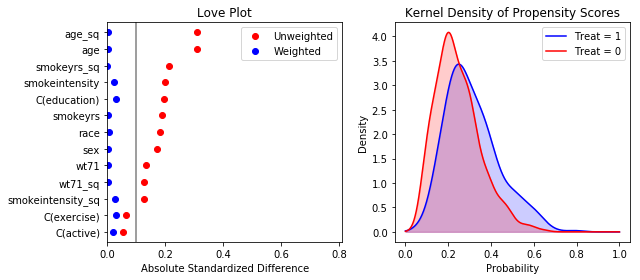

In [15]:
iptw.run_diagnostics(iptw_only=True)

                     Weight Positivity Diagnostics
If the mean of the weights is far from either the min or max, this may
 indicate the model is incorrect or positivity is violated
Average weight should be
	1.0 for stabilized
	2.0 for unstabilized
----------------------------------------------------------------------
Mean weight:            0.996
Standard Deviation:     0.282
Minimum weight:         0.355
Maximum weight:         4.093

                Standardized Mean Differences
                      smd_w     smd_u
labels                               
C(education)       0.064454  0.195789
C(exercise)        0.029453  0.056850
C(active)          0.013923  0.074001
sex                0.002810 -0.160263
race               0.008282 -0.177051
age               -0.010085  0.281981
age_sq            -0.012405  0.281608
smokeintensity    -0.042325 -0.216675
smokeintensity_sq -0.031948 -0.128894
smokeyrs          -0.018407  0.158918
smokeyrs_sq       -0.018614  0.178899
wt71              -0

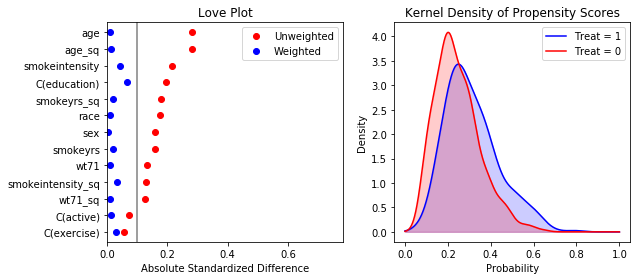

In [16]:
iptw.run_diagnostics(iptw_only=False)

## Conclusion
That concludes chapter 12 of "Causal Inference" by Hernan and Robins. Please review the other tutorials on this site for more details and features of `IPTW`, `IPMW`, and other functionalities. In the next tutorial, we will go through the parametric g-formula